## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [52]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [53]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [54]:
# ваш код здесь
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum'
}).reset_index()
daily_data.head(1)


#data['date'] = pd.to_datetime(data['date'])
#data.groupby('group')['date'].agg(['min', 'max'])


,date,group,user_id,purchase
45,2021-01-24,B,3727,449


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [55]:
# ваш код здесь
daily_data = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'     
}).reset_index()
daily_data

#пример
#print('Количество посещений сайта в группах А и B:')
#display(data.groupby('group')['user_id'].agg('count'))

,group,user_id,purchase,price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [56]:
# ваш код здесь
data_a = set(data[data['group'] == 'A']['user_id'])
data_b = set(data[data['group'] == 'B']['user_id'])
user_intersection = data_a.intersection(data_b)
print(len(user_intersection))

#print('Число пользователей, попавших в обе группы: ', len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [57]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

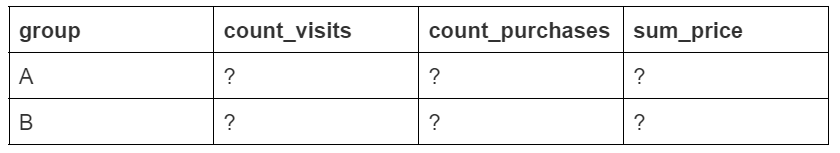
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [58]:
# ваш код здесь
updated_data_count = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum' 
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
updated_data_count

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

*Вывод*: разница в количествах посещений обоих вариантов страницы составляет 74. На такой большой выборке (около 292000 посетителей), разница не значительная, значит можно говорить о сбалансированности выборок.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [59]:
# ваш код здесь
updated_data_count['conversion'] = round((updated_data_count['count_purchases'] / updated_data_count['count_visits'])*100, 2)
updated_data_count['mean_check'] = round(updated_data_count['sum_price'] / updated_data_count['count_purchases'], 2)
updated_data_count.head()
#print('Конверсия (в процентах) в группах А и B:')
#display(grouped['conversion'].round(2))

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

*Выводы*: из таблицы мы видим, что конверсия варианта А незначительно больше варианта В, в свою очередь вариант B эффективнее варианта А по среднему чеку, который у варианта В больше.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [60]:
# ваш код здесь
purchasing_power = pd.pivot_table(updated_data,
               index=['price'],
               columns=['group'],
               values='purchase',
               aggfunc='sum')

display(purchasing_power)

#pivot = updated_data[updated_data['price'] > 0].pivot_table(
#    index='group', 
 #   columns='price', 
 #   values='purchase', 
 #   aggfunc='sum'
#)
# цена должна быть ГОРИЗОНТАЛЬНО(!)

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


<AxesSubplot: xlabel='group', ylabel='price'>

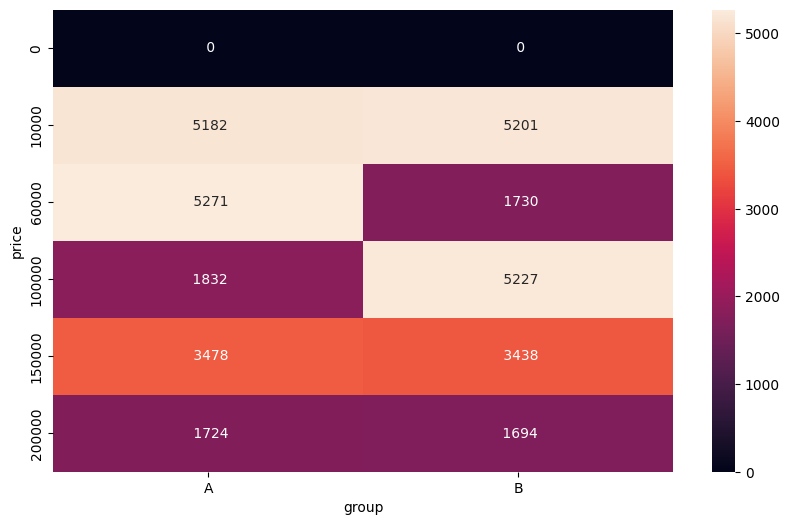

In [62]:

# ваш код здесь
fig = plt.subplots(figsize=(10,6))
sns.heatmap(purchasing_power, annot=True, fmt=" d")


#fig = plt.figure(figsize=(10, 4))
#ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
#ax.set_title('Тепловая карта покупательской способности туров в группах');

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

*Вывод*: из графика видно, что покупательская способность участников в группе А выше чем участников группы В по турам за 60 000 руб. И наоборот, покупательская спсобность участников групы В выше по турам за 100 000 руб.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [64]:
# ваш код здесь
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum' 
}).reset_index()
daily_data['conversion'] = round((daily_data['purchase'] / daily_data['user_id'])*100, 2)
daily_data['mean_check'] = round(daily_data['price'] / daily_data['purchase'], 2)
daily_data.head()

,date,group,user_id,purchase,price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.01
1,2021-01-02,B,2861,345,29660000,12.06,85971.01
2,2021-01-03,A,6596,748,62000000,11.34,82887.70
3,2021-01-03,B,6619,754,65960000,11.39,87480.11
4,2021-01-04,A,6566,799,64250000,12.17,80413.02


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [65]:
# ваш код здесь
daily_data['cum_user_id'] = daily_data.groupby(['group'])['user_id'].cumsum()
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase'].cumsum()
daily_data['cum_price'] = daily_data.groupby(['group'])['price'].cumsum()
daily_data['cum_conversion'] = round(daily_data['cum_purchase']/daily_data['cum_user_id'] * 100, 2)
daily_data['cum_mean_check'] = round(daily_data['cum_price']/daily_data['cum_purchase'])
daily_data[daily_data['date'] == '2021-01-20']
daily_data[daily_data['date'] == '2021-01-12']

#print('Конверсия 3 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2))

,date,group,user_id,purchase,price,conversion,mean_check,cum_user_id,cum_purchase,cum_price,cum_conversion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.16,86113.21,68852,8198,668070000,11.91,81492.0
21,2021-01-12,B,6635,807,70560000,12.16,87434.94,69251,8236,727670000,11.89,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

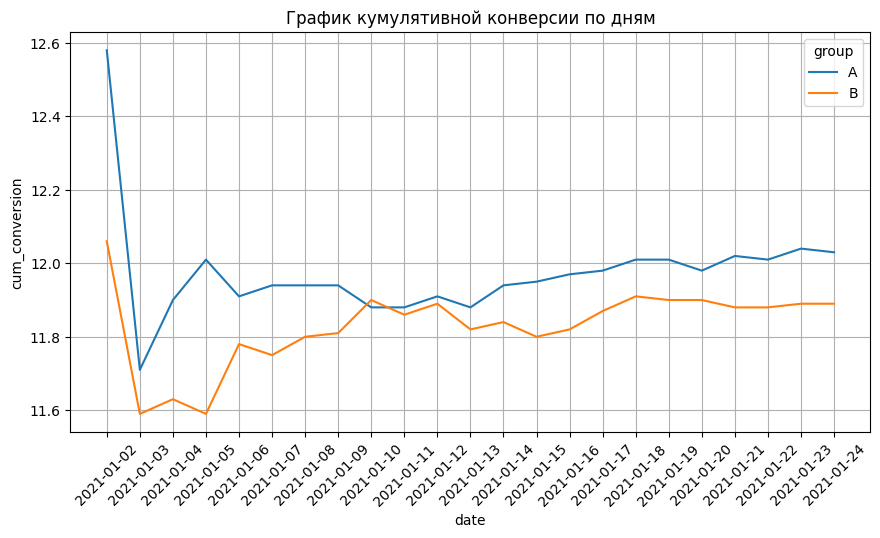

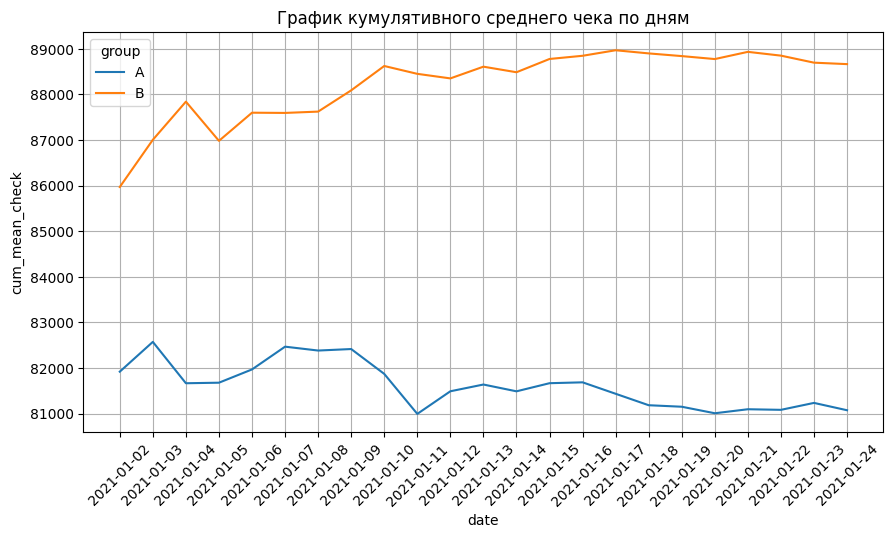

In [66]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

*Вывод*: Судя по графику кумулятивной конверсии по дням, можно сказать, что значения метрик стабилизировались с 11 января 2021 года. А так же то, что показатели в группе А (по конверсии) стабильно (но незначительно) выше.<br>
По графику кумулятивного среднего чека по дням следует, что значения метрик стабилизированы, показатели в группе В выше, чем в группе А.

пример решения данной задачи

In [ ]:
# создаем фигуру размером 15x5
fig, axes= plt.subplots(1, 2, figsize=(15, 5))
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])
# задаем подпись к графику
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного среднего чека по дням')
# задаем поворот меток на оси абсцисс
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)
# задаем отображение сетки
axes[0].grid(True);
axes[1].grid(True);

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [67]:
# ваш код здесь
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [68]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

*Выводы*: так как p-value больше уровня значимости, то мы не можем отвергнуть нулевую гипотезу, значит принимаем, что конверсии в группах А и В равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [69]:
# ваш код здесь
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [70]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [71]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)



# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

*Вывод*: между доверительными интервалами в группах А и В есть перекрытие, точнее доверительный интервал группы А входит в доверительный интервал группы В.<br>
Можно сказать, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Поэтому проверим эту мысль рассчитав доверительный интервал для разницы конверсий.<br><br>
Доверительный интервал для разницы конверсий показывает нам, что варианты А и В равнозначны по метрике конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [72]:
# ваш код здесь
# повторю построение таблицы с разбиением на группы
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum' 
}).reset_index()
daily_data['conversion'] = round((daily_data['purchase'] / daily_data['user_id'])*100, 2)
daily_data['mean_check'] = round(daily_data['price'] / daily_data['purchase'], 2)
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

In [73]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределение нормальное в обеих группах'
H1 = 'Распределение отличное от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение нормальное в обеих группах


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [74]:
# ваш код здесь
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data_a['mean_check'],
    b=daily_data_b['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

*Выводы*: есть статистическая разница между ежедневными средними чеками в группах - Ежедневный средний чек в группе А меньше чем в группе B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [75]:
# ваш код здесь
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
#a_daily_data = daily_data[daily_data['group'] == 'A']
#b_daily_data = daily_data[daily_data['group'] == 'B']
 
params_a = {
    'n': daily_data_a['user_id'].count(), # размер выборки
    'x_mean': daily_data_a['mean_check'].mean(), # выборочное средние
    'x_std': daily_data_a['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': daily_data_b['user_id'].count(),# размер выборки
    'x_mean': daily_data_b['mean_check'].mean(), # выборочное средние
    'x_std': daily_data_b['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Вывод:  Очевидно, что перекрытия между интервалами нет. Но для группы В доверительный интервал значительно выше.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*По проделанной работе можно сделать следющие выводы:*
1. По конверсии. Варианты А и В равнозначны по метрике конверсии (что подтверждено статистическим тестом, доверительными интервалами и доверительным интервалом для разности конверсий).
2. По среднему чеку. Ежедневный средний чек в группе В больше чем в группе А (что подтверждено статистическим тестом).

ПРИМЕР ВЫВОДЫ ИЗ ОБУЧЕНИЯ:

На основе анализа результатов A/B-теста можно сказать, что вариант B является более выгодным для бизнеса, чем вариант А, так как у него наблюдается та же конверсия, но средний чек выше.